In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Dataset/'

In [1]:
import pandas as pd

In [12]:
positive_df = pd.read_csv('positive_sample_7500_1.csv', header=None)
negative_df = pd.read_csv('negative_sample_7500_1.csv', header=None)

In [13]:
def load_protein_sequences(file_path):
    protein_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                protein_dict[parts[0]] = parts[1]
    return protein_dict
protein_sequences = load_protein_sequences('protein_sequences.txt')

In [4]:
len(positive_df[0])

7501

In [14]:
positive_df_2 = pd.DataFrame([positive_df[1],positive_df[0]]).transpose()
negative_df_2 = pd.DataFrame([negative_df[1],negative_df[0]]).transpose()

In [15]:
positive_df = pd.concat([positive_df,positive_df_2])
negative_df = pd.concat([negative_df,negative_df_2])

In [16]:
positive_df[2] = 1
negative_df[2] = 0
data = pd.concat([positive_df, negative_df],ignore_index=True)

In [17]:
data = data.sample(frac=1,random_state=42).reset_index(drop=True)

In [19]:
data[0] = [protein_sequences[x] for x in data[0]]
data[1] = [protein_sequences[x] for x in data[1]]

KeyError: 'Q3SY89'

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
sequences1 = data[0].values  # Amino acid sequences of protein 1
sequences2 = data[1].values  # Amino acid sequences of protein 2
labels = data[2].values     # Interaction labels (0 or 1)

In [11]:
tokenizer = Tokenizer(char_level=True)  # Tokenize at character level
tokenizer.fit_on_texts(sequences1 + sequences2)

# Convert sequences to numerical tokens
encoded_sequences1 = tokenizer.texts_to_sequences(sequences1)
encoded_sequences2 = tokenizer.texts_to_sequences(sequences2)

# Pad sequences to a fixed length (choose an appropriate maxlen)
maxlen = 100  # Example max length, adjust as needed
padded_sequences1 = pad_sequences(encoded_sequences1, maxlen=maxlen, padding='post')
padded_sequences2 = pad_sequences(encoded_sequences2, maxlen=maxlen, padding='post')

In [12]:
train_sequences1, test_sequences1, train_sequences2, test_sequences2, train_labels, test_labels = train_test_split(
        padded_sequences1, padded_sequences2, labels, test_size=0.2, random_state=42
    )

In [13]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size for embedding layer

# Input layers for protein sequences
input1 = Input(shape=(maxlen,))
input2 = Input(shape=(maxlen,))

# Embedding layers to represent amino acids as vectors
embedding_layer = Embedding(vocab_size, 128)  # 128-dimensional embeddings
embedded_sequences1 = embedding_layer(input1)
embedded_sequences2 = embedding_layer(input2)

# LSTM layers to process the sequences
lstm_layer = LSTM(64)  # 64 LSTM units
lstm_output1 = lstm_layer(embedded_sequences1)
lstm_output2 = lstm_layer(embedded_sequences2)

# Concatenate LSTM outputs
merged = concatenate([lstm_output1, lstm_output2])

# Dense layers for classification
output = Dense(1, activation='sigmoid')(merged)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.fit([train_sequences1, train_sequences2], train_labels, epochs=20, batch_size=32)  # Adjust epochs and batch size as needed

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4967 - loss: 0.6938
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4806 - loss: 0.6934
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4931 - loss: 0.6932
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4896 - loss: 0.6934
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5017 - loss: 0.6931
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4963 - loss: 0.6932
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4904 - loss: 0.6932
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4985 - loss: 0.6932
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5041 - loss: 0.6932
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4903 - loss: 0.6932
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4935 - loss: 0.6932
Epoch 12/20
250/250 ━━━━━━━━━━━━━━

In [16]:
loss, accuracy = model.evaluate([test_sequences1, test_sequences2], test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5080 - loss: 0.6931
Test Loss: 0.6931553483009338
Test Accuracy: 0.4952428638935089


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


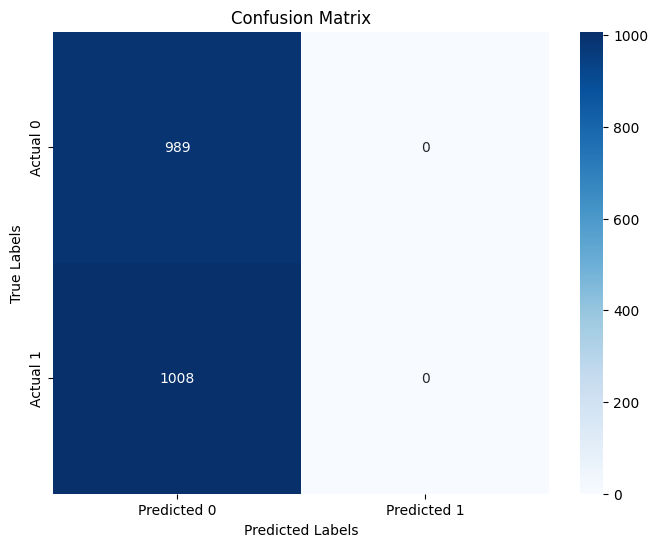

In [18]:
# prompt: print confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test set
predictions = model.predict([test_sequences1, test_sequences2])
predicted_labels = (predictions > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: print accuracy, precision, recall, f1 score

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming predicted_labels and test_labels are already defined from your previous code

precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8858287334442139
Precision: 0.880859375
Recall: 0.8948412698412699
F1 Score: 0.8877952755905512
